<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1 | Assessment of damage associated with Russia's invasion of Ukraine in 2022</b></p>
</div>

Download all libraries needed for this project

In [1]:
import pandas as pd
import numpy as np
import folium as F
%matplotlib inline 
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from math import log10, floor

# print('Matplotlib version: ', mpl.__version__)
# print(plt.style.available)
mpl.style.use(['ggplot'])

Read the CSV files into a Pandas DataFrame

In [2]:
russian_personnel = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')
russian_equipment = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')

## Data Wrangling
### Let's start by getting a basic understanding of the DataFrame and cleaning the data

In [3]:
russian_personnel

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0
1,2022-02-26,3,4300,about,0
2,2022-02-27,4,4500,about,0
3,2022-02-28,5,5300,about,0
4,2022-03-01,6,5710,about,200
...,...,...,...,...,...
101,2022-06-06,103,31250,about,498
102,2022-06-07,104,31360,about,498
103,2022-06-08,105,31500,about,498
104,2022-06-09,106,31700,about,498


In [4]:
#remove confusing columns and set index for sorting by date.
russian_personnel.drop(['personnel', 'personnel*'], axis=1, inplace=True)
russian_personnel.set_index('date', inplace=True)
russian_personnel.info()
russian_personnel.head()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 2022-02-25 to 2022-06-10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   day     106 non-null    int64
 1   POW     106 non-null    int64
dtypes: int64(2)
memory usage: 2.5+ KB


,day,POW
date,,
2022-02-25,2,0
2022-02-26,3,0
2022-02-27,4,0
2022-02-28,5,0
2022-03-01,6,200


In [5]:
russian_equipment

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles,greatest losses direction
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2022-06-06,103,211,176,1386,3400,690,207,NaN,NaN,551,13,96,53.0,NaN,2395.0,125.0,Slov'yansʹk
102,2022-06-07,104,212,177,1390,3416,694,207,NaN,NaN,553,13,96,53.0,NaN,2405.0,125.0,Slov'yansʹk
103,2022-06-08,105,212,178,1393,3429,703,213,NaN,NaN,559,13,96,53.0,NaN,2406.0,125.0,Slov'yansʹk
104,2022-06-09,106,212,178,1398,3438,711,213,NaN,NaN,562,13,96,53.0,NaN,2421.0,125.0,Bahmut


In [6]:
#fill empty spaces in Dataframe with zeroes and set index for sorting by date.
russian_equipment = russian_equipment.fillna(0)
russian_equipment.set_index('date', inplace=True)
russian_equipment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 2022-02-25 to 2022-06-10
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day                        106 non-null    int64  
 1   aircraft                   106 non-null    int64  
 2   helicopter                 106 non-null    int64  
 3   tank                       106 non-null    int64  
 4   APC                        106 non-null    int64  
 5   field artillery            106 non-null    int64  
 6   MRL                        106 non-null    int64  
 7   military auto              106 non-null    float64
 8   fuel tank                  106 non-null    float64
 9   drone                      106 non-null    int64  
 10  naval ship                 106 non-null    int64  
 11  anti-aircraft warfare      106 non-null    int64  
 12  special equipment          106 non-null    float64
 13  mobile SRBM system         106 non-null

In [7]:
#Consolidating repetitive columns and deleting blank ones
russian_equipment['vehicles and fuel tanks'] += russian_equipment['fuel tank']
russian_equipment['special equipment'] += russian_equipment['military auto']

russian_equipment.drop(columns={'mobile SRBM system', 'fuel tank', 'military auto', 'greatest losses direction'}, inplace=True)

#Change all numeric data to integer.
russian_equipment = russian_equipment.astype(int)
russian_equipment.info()
russian_equipment

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 2022-02-25 to 2022-06-10
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   day                      106 non-null    int64
 1   aircraft                 106 non-null    int64
 2   helicopter               106 non-null    int64
 3   tank                     106 non-null    int64
 4   APC                      106 non-null    int64
 5   field artillery          106 non-null    int64
 6   MRL                      106 non-null    int64
 7   drone                    106 non-null    int64
 8   naval ship               106 non-null    int64
 9   anti-aircraft warfare    106 non-null    int64
 10  special equipment        106 non-null    int64
 11  vehicles and fuel tanks  106 non-null    int64
 12  cruise missiles          106 non-null    int64
dtypes: int64(13)
memory usage: 11.6+ KB


,day,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles
date,,,,,,,,,,,,,
2022-02-25,2,10,7,80,516,49,4,0,2,0,100,60,0
2022-02-26,3,27,26,146,706,49,4,2,2,0,130,60,0
2022-02-27,4,27,26,150,706,50,4,2,2,0,130,60,0
2022-02-28,5,29,29,150,816,74,21,3,2,5,291,60,0
2022-03-01,6,29,29,198,846,77,24,3,2,7,305,60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-06,103,211,176,1386,3400,690,207,551,13,96,53,2395,125
2022-06-07,104,212,177,1390,3416,694,207,553,13,96,53,2405,125
2022-06-08,105,212,178,1393,3429,703,213,559,13,96,53,2406,125


## Data Visualization
## Problem 1
##### Visually represent the country being invaded.

In [8]:
## Coordinates as at 03/31/2021 obtained from googlemaps
ukraine_latitude = 48.383022 
ukrain_longitude = 31.1828699
ukraine_map = F.Map(location=[ukraine_latitude, ukrain_longitude], tiles="Stamen Terrain", zoom_start=6.49)

kiev = F.map.FeatureGroup()

kiev_latitude =50.4500336
kiev_longitude =30.5241361
kiev.add_child(F.features.CircleMarker([kiev_latitude, kiev_longitude], radius=5, color="red", fill_color="blue"))
ukraine_map.add_child(kiev)

F.Marker([kiev_latitude, kiev_longitude], popup="Ukraine's Capital").add_to(ukraine_map)

ukraine_map

## Problem 2
##### Show the total Prisoners of War per day recorded in the Personel table.


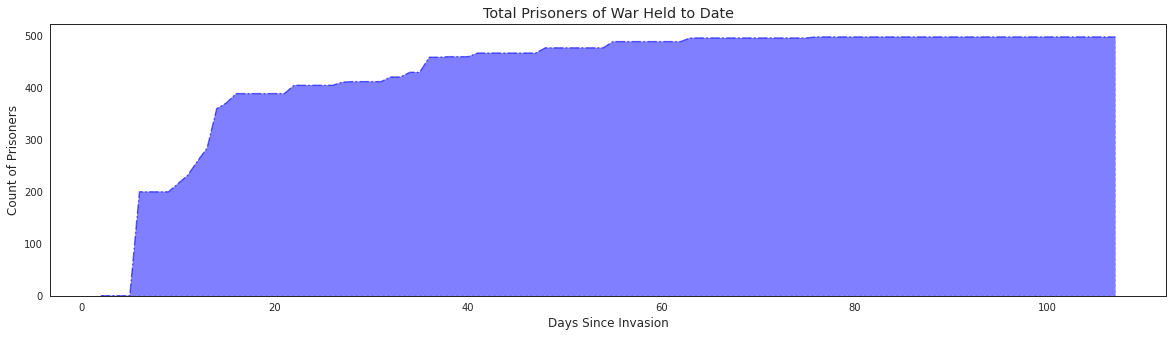

In [9]:
# Set graph style
sns.set_style('white')

# Refine data
pow_data = russian_personnel[["day", "POW"]]
pow_data.reset_index('date', inplace=True)

# Create and label plot
pow_data.plot(kind='area', x='day', y='POW', color='blue', alpha=.5, figsize=(20,5), legend=False, linestyle="-.")
plt.title('Total Prisoners of War Held to Date')
plt.xlabel('Days Since Invasion')
plt.ylabel("Count of Prisoners")
plt.show()

## Problem 3
##### What is the daily change in POW and Total POW?

In [10]:
# Helper Variables
last = 0
increase = []

# Calculate daily change in POW
for i in (pow_data['POW'].values):
    count = i - last
    increase.append(count)
    last = i
    
# Assign new values to table    
pow_data['Daily Increase in Prisoners of War'] = increase

# Style table
pow_data_ = pow_data[['day', 'POW', 'Daily Increase in Prisoners of War']].set_index('day')
pow_data_.rename(columns={'POW':'Daily Total Prisoners of War'}, inplace=True)
pow_data_

,Daily Total Prisoners of War,Daily Increase in Prisoners of War
day,,
2,0,0
3,0,0
4,0,0
5,0,0
6,200,200
...,...,...
103,498,0
104,498,0
105,498,0


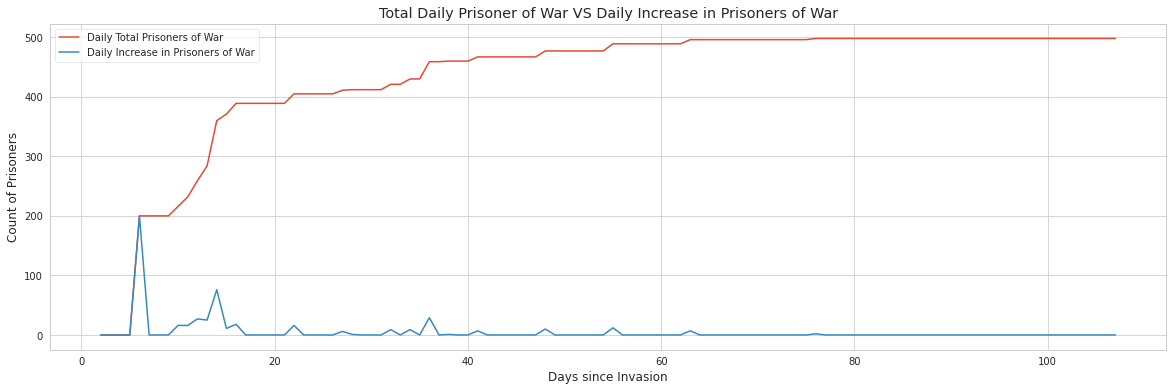

In [11]:
# Set graph style
sns.set_style('whitegrid')

# Create graph
pow_data_.plot(figsize=(20,6))
plt.xlabel('Days since Invasion')
plt.ylabel('Count of Prisoners')
plt.title("Total Daily Prisoner of War VS Daily Increase in Prisoners of War")
plt.show()

## Problem 4
##### Visualize the daily change in POW.

count    98.000000
mean      3.040816
std       9.537683
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      76.000000
Name: Daily Increase in Prisoners of War, dtype: float64


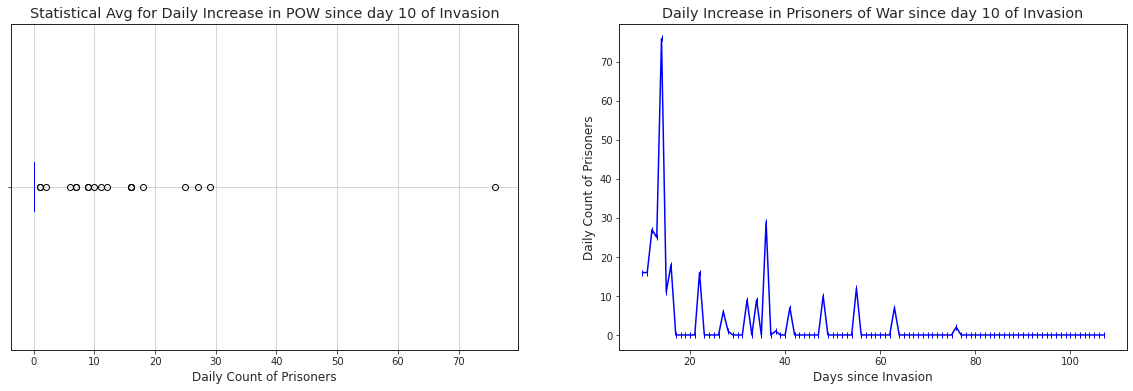

In [12]:
sns.set_style('ticks')

# Create Plot Object
fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Assessing data after day 10 when POW is within a more narrow/normalized range. See above graph
plot_data1=pow_data_['Daily Increase in Prisoners of War'][8:]
print(plot_data1.describe())

# Subplot 1: Box plot
plot_data1.plot(kind='box', color='blue', figsize=(20, 6), vert=False, ax=ax0, notch=True, label="", 
                grid=True, patch_artist=True) 
ax0.set_title(f'Statistical Avg for Daily Increase in POW since day {plot_data1.index[0]} of Invasion')
ax0.set_xlabel('Daily Count of Prisoners')

# Subplot 2: Line plot
plot_data1.plot(color='blue', figsize=(20,6), ax=ax1, marker="|")
ax1.set_xlabel('Days since Invasion')
ax1.set_ylabel('Daily Count of Prisoners')
ax1.set_title(f"Daily Increase in Prisoners of War since day {plot_data1.index[0]} of Invasion")

# Print graph
plt.show()


In [13]:
print(f'There are approximately {round(plot_data1.describe()[1])} daily prisoners of war on average.')

There are approximately 3 daily prisoners of war on average.


## Problem 5
##### What Is the total daily loss for all equipment?

In [14]:
# Structure data from dataset
daily_total_equip_loss = russian_equipment.reset_index('date')
daily_total_equip_loss.drop(columns={'date'}, inplace=True)
daily_total_equip_loss.set_index('day', inplace=True)

# Create new dataframe for graph object
daily_total_equip_loss['Daily Total Equipment Loss'] = pd.DataFrame(daily_total_equip_loss.sum(axis=1))
daily_total_equip_loss

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,Daily Total Equipment Loss
day,,,,,,,,,,,,,
2,10,7,80,516,49,4,0,2,0,100,60,0,828
3,27,26,146,706,49,4,2,2,0,130,60,0,1152
4,27,26,150,706,50,4,2,2,0,130,60,0,1157
5,29,29,150,816,74,21,3,2,5,291,60,0,1480
6,29,29,198,846,77,24,3,2,7,305,60,0,1580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,211,176,1386,3400,690,207,551,13,96,53,2395,125,9303
104,212,177,1390,3416,694,207,553,13,96,53,2405,125,9341
105,212,178,1393,3429,703,213,559,13,96,53,2406,125,9380


In [15]:
# Create and show graph
plot_data2 = daily_total_equip_loss[['Daily Total Equipment Loss']]
fig=px.scatter(plot_data2, x=plot_data2.index, y='Daily Total Equipment Loss', marginal_x='box', 
               color='Daily Total Equipment Loss')
fig.update_layout(plot_bgcolor='rgba(0,5,5,0)')
fig.update_layout(title={'text':'Total Equipment Lost Per Day','y':0.93,'x':0.5,'xanchor':'center','yanchor':'top'})
fig.show()

## Problem 6
##### Create a word map visual to show the equipment types with the highest percentage loss in total equipment loss.

In [16]:
sns.set_style('white')
# Get the most recent loss data
total = int(daily_total_equip_loss.iloc[-1: , -1:].values)

total_loss = daily_total_equip_loss.iloc[-1: , :-1]
total_loss.reset_index(inplace=True)
total_loss = pd.DataFrame(total_loss.drop('day', axis=1).transpose()).reset_index()
total_loss.rename(columns={'index':'Equipment', 0:'Count'}, inplace=True)
total_loss.set_index('Equipment', inplace=True)
total_loss

,Count
Equipment,
aircraft,212
helicopter,178
tank,1409
APC,3450
field artillery,712
MRL,222
drone,572
naval ship,13
anti-aircraft warfare,97


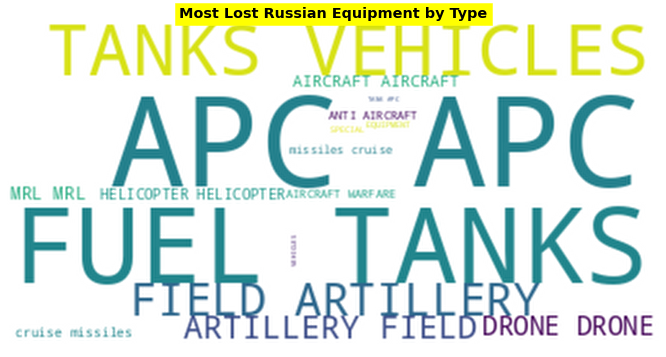

In [17]:
# duplicate equipment name based on how much they contribute to total loss
word_string=""
max_words = total_loss.mean()/2
for equipment in total_loss.index:
     times_repeat = int(total_loss.loc[equipment, 'Count']/total * max_words)
     word_string = word_string.upper() + ((equipment + " ") * times_repeat)

# create word cloud
word_cloud = WordCloud(background_color = 'white').generate(word_string)

# Display cloud
plt.figure(figsize=(20,6))
plt.imshow(word_cloud, interpolation='bessel')
plt.title('Most Lost Russian Equipment by Type', fontweight='bold', color='black', backgroundcolor='yellow')
plt.axis('off')
plt.show()

## Problem 7
##### How much equipment did Russia lose in the first 5 days of the invasion?

In [18]:
daily_total_equip_loss.head(4)


,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,Daily Total Equipment Loss
day,,,,,,,,,,,,,
2,10,7,80,516,49,4,0,2,0,100,60,0,828
3,27,26,146,706,49,4,2,2,0,130,60,0,1152
4,27,26,150,706,50,4,2,2,0,130,60,0,1157
5,29,29,150,816,74,21,3,2,5,291,60,0,1480


## Problem 8
##### What is the most recent count of equipment loss?

In [19]:
daily_total_equip_loss.tail(1)

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,Daily Total Equipment Loss
day,,,,,,,,,,,,,
107,212,178,1409,3450,712,222,572,13,97,54,2438,125,9482


## Problem 9
##### Is there any correlation between the POW and equipment loss?

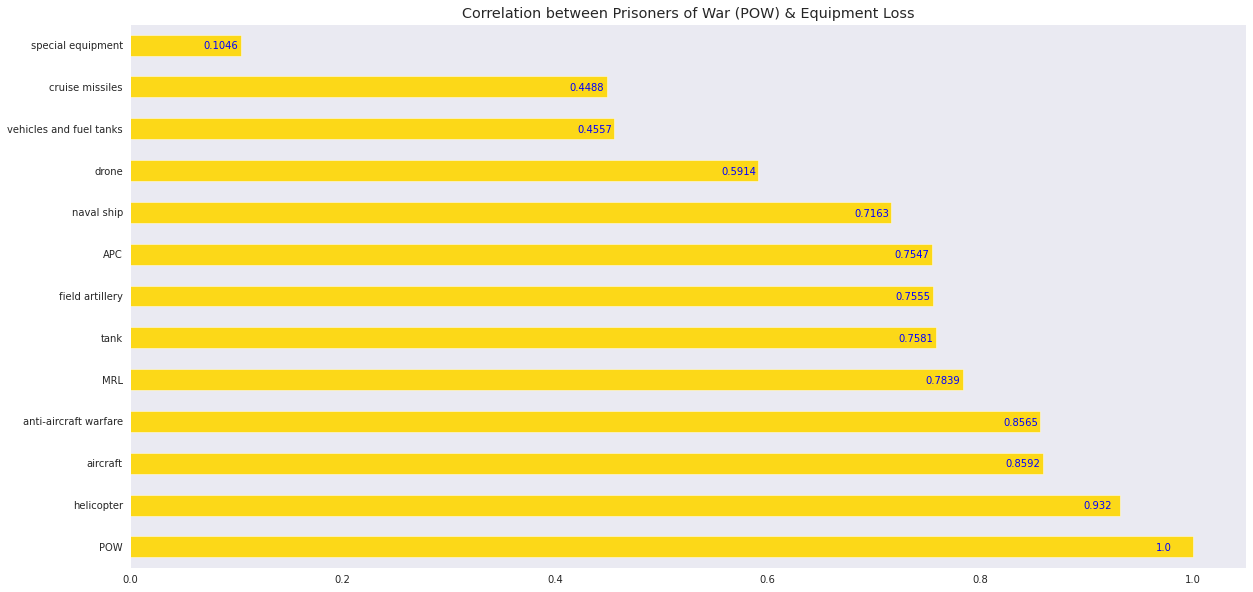

In [20]:
sns.set_style('dark')

merge = pd.merge(russian_equipment, russian_personnel).drop(['day'], axis=1)
merged = merge.corr()['POW'].sort_values(ascending=False)

merged.plot.barh(title='Correlation between Prisoners of War (POW) & Equipment Loss',
                 figsize=(20,10), alpha=.9, color='gold')
for index, value in enumerate(merged):
    value = round(value, 4)
    label = format(value)
    if value>0:
        value-=.035
    else:
        value+=.003
    plt.annotate(label, xy=(value, index-.1), color='blue')

## Problem 10
##### What inferences can you make from the relationship between POW and Equipment loss?

In [21]:
merged.describe()

count    13.000000
mean      0.693599
std       0.241345
min       0.104575
25%       0.591424
50%       0.755469
75%       0.856542
max       1.000000
Name: POW, dtype: float64

In [22]:
m = merged.describe()
k = merged.keys()
v = merged.values

print(f"There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. As \
the POW increases, so does the overall equipment loss. The strength in correlation, ranges from {round(v[1], 3)} ({k[1]}) \
to {round(v[-1], 3)} ({k[-1]}). The median correlation is {round(m[-3], 3)} falling between {k[6]}s and {k[7]}s. The \
standard deviation is {round(m[2], 3)} which indicated that the there is not much variability in the data; all points seem \
to be close to the mean or average correlation. \n\n\
It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss especially \
the loss of {k[1]}s by at least {round(m[1], 3)} when compared to POW.")

There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. As the POW increases, so does the overall equipment loss. The strength in correlation, ranges from 0.932 (helicopter) to 0.105 (special equipment). The median correlation is 0.755 falling between field artillerys and APCs. The standard deviation is 0.241 which indicated that the there is not much variability in the data; all points seem to be close to the mean or average correlation. 

It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss especially the loss of helicopters by at least 0.694 when compared to POW.


<!-- It should be noted that the strongest correlation exists not between the equipmet type with the highest loss({}) but with the type that had the ({}) highest loss. -->


<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>- Thank you</b></p>
</div>
